In [1]:
import matplotlib.pyplot as plt
from vc_sample.density_estimation import KernelDensityEstimator
from vc_sample.kernels import GaussianKernel, kernel_scale_factor
from vc_sample.void_and_cluster import VoidAndCluster

/opt/homebrew/Caskroom/miniforge/base/envs/vc_sample/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import make_s_curve, make_circles

s_curve, s_curve_color = make_s_curve(n_samples=2000)

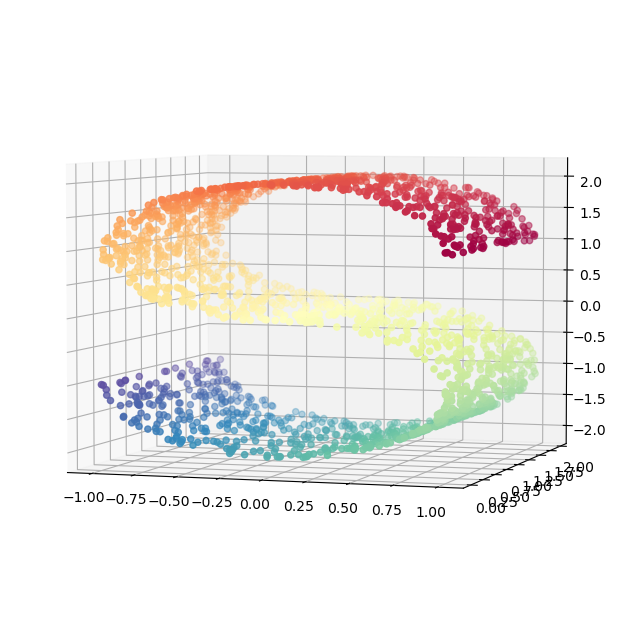

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
#ax.set_title('The S-curve: A 2-dimensional manifold embedded in 3D')
ax.scatter(s_curve[:, 0], s_curve[:, 1], s_curve[:, 2], c=s_curve_color,
           cmap=plt.cm.Spectral)
ax.view_init(4, -72)

It is not possible to find a fixed kernel bandwidth that allows us to
sample along the s-curve.

The reliance on the fixed bandwith kernel is thus problematic for stratified sampling
on a manifold embedded in a higher dimensional space.

In [5]:
num_samples = 200

kernel_scale1d = 5.0 * kernel_scale_factor(dimensionality=1,
                                           num_points=s_curve.shape[0],
                                           num_samples=num_samples)
kernel_scale1d

50.0

In [6]:
density_estimator = KernelDensityEstimator(s_curve,
                                           GaussianKernel(sigma=kernel_scale1d))
vc = VoidAndCluster(density_estimator, s_curve.shape[0], num_initial_samples=10)

sample_indices = vc.sample(size=num_samples)
curve_samples = s_curve[sample_indices]
curve_color_samples = s_curve_color[sample_indices]

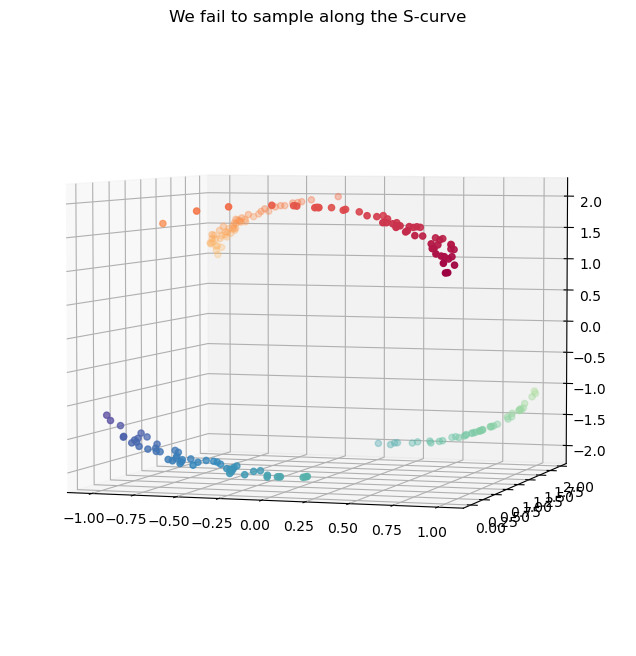

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.set_title('We fail to sample along the S-curve')
ax.scatter(curve_samples[:, 0], curve_samples[:, 1], curve_samples[:, 2],
           c=curve_color_samples, cmap=plt.cm.Spectral)
ax.view_init(4, -72)


### Estimating density on the manifold

We now use ``UMAPDensityEstimator`` to perform density estimation not in the 3D euclidean
space, but directly on the embedded manifold (the S-curve).

In detail, the density is estimated on the graph used by the UMAP (https://umap-learn.readthedocs.io/) dimensionality reduction technique. This graph describes the topological connectedness of the embedded manifold. Sampling the graph with the void and cluster technique leads to optimally stratified samples on the embedded manifold.

In [8]:
from vc_sample.density_estimation import UMAPDensityEstimator

ude = UMAPDensityEstimator(s_curve, n_neighbors=10)
rho = ude.estimate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


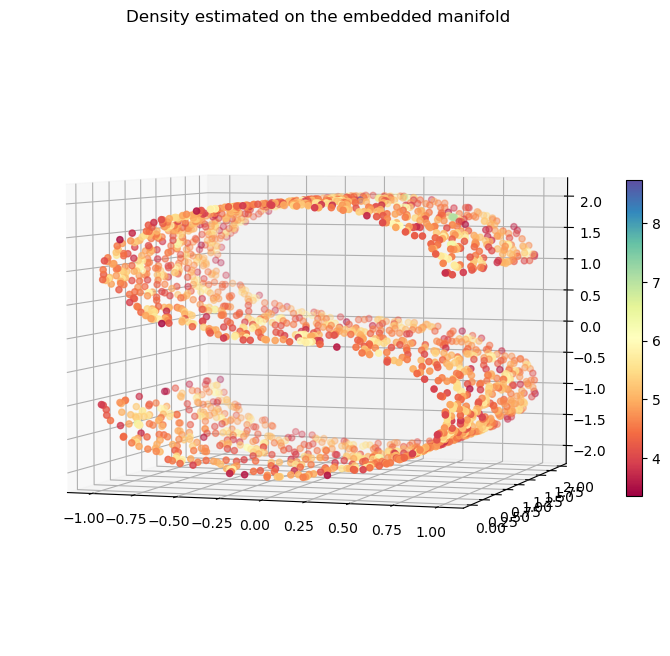

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.set_title('Density estimated on the embedded manifold')
v = ax.scatter(s_curve[:, 0], s_curve[:, 1], s_curve[:, 2], c=rho,
               cmap=plt.cm.Spectral)
ax.view_init(4, -72)
fig.colorbar(v, ax=ax, fraction=0.017, pad=0.0);

In [10]:
vc = VoidAndCluster(ude, s_curve.shape[0], num_initial_samples=100)

sample_indices = vc.sample(size=num_samples)
curve_samples = s_curve[sample_indices]
curve_color_samples = s_curve_color[sample_indices]

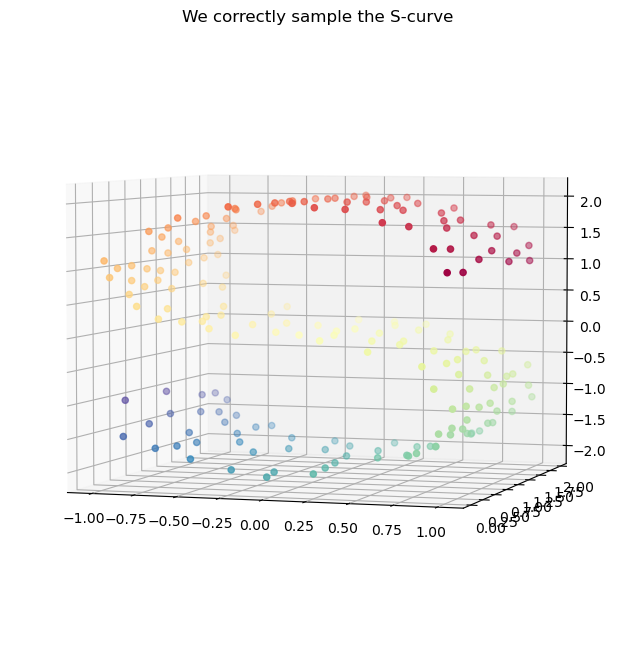

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.set_title('We correctly sample the S-curve')
ax.scatter(curve_samples[:, 0], curve_samples[:, 1], curve_samples[:, 2],
           c=curve_color_samples, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Large circle containing a small inner circle

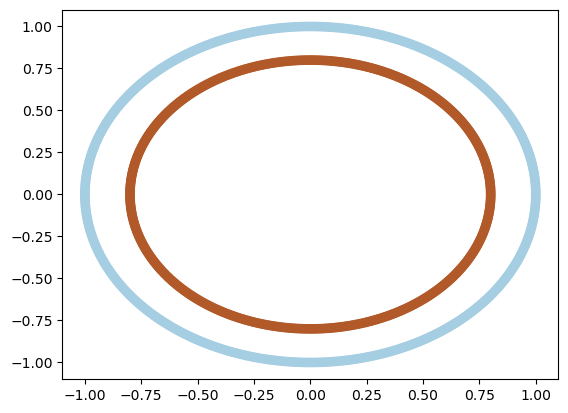

In [12]:
circles, circles_class = make_circles(n_samples=1000)

fig, ax = plt.subplots(1, 1)
ax.scatter(circles[:, 0], circles[:, 1], c=circles_class, cmap='Paired');

In [13]:
from vc_sample.density_estimation import UMAPDensityEstimator

ude = UMAPDensityEstimator(circles, n_neighbors=15)
rho = ude.estimate()

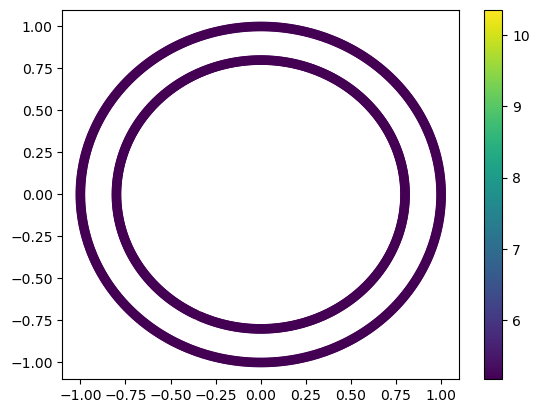

In [14]:
plt.scatter(circles[:, 0], circles[:, 1], c=rho, cmap='viridis');
plt.colorbar();

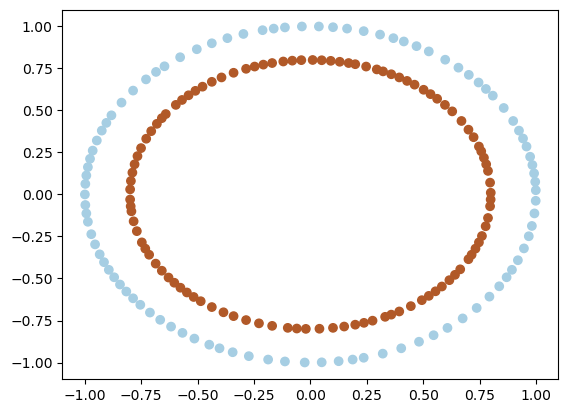

In [15]:
vc = VoidAndCluster(ude, circles.shape[0], num_initial_samples=50)

sample_indices = vc.sample(size=num_samples)

circles_samples = circles[sample_indices]
circles_class_samples = circles_class[sample_indices]

plt.scatter(circles_samples[:, 0], circles_samples[:, 1], c=circles_class_samples,
            cmap='Paired');